In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import misc
from scipy import ndimage

import imageio

import tensorflow as tf

import scipy

from skimage import metrics

import matplotlib.pyplot as plt
%matplotlib inline  


In [2]:
def imread(path, is_grayscale=True):
    """
    Read image from the giving path.
    Default value is gray-scale, and image is read by YCbCr format as the paper.
    """
    if is_grayscale:
        return imageio.imread(path, as_gray=True, pilmode='YCbCr').astype(np.float32)
    else:
        return imageio.imread(path, pilmode='YCbCr').astype(np.float32)


In [3]:
def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.

    We need to find modulo of height (and width) and scale factor.
    Then, subtract the modulo from height (and width) of original image size.
    There would be no remainder even after scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [4]:
def preprocess(path, scale=3):
    """
    Preprocess single image file
      (1) Read original image as YCbCr format (and grayscale as default)
      (2) Normalize
      (3) Apply image file with bicubic interpolation
    Args:
      path: file path of desired file
      input_: image applied bicubic interpolation (low-resolution)
      label_: image with original resolution (high-resolution)
    """
    image = imread(path, is_grayscale=True)
    label_ = modcrop(image, scale)

    # Must be normalized
    
    label_ = label_ / 255.
    


    input_ = scipy.ndimage.interpolation.zoom(label_, (1. / scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale / 1.), prefilter=False)

    return input_, label_

In [5]:
"""Define the model weights and biases 
"""
## ------ Add your code here: set the weight of three conv layers
# replace 'None' with your hyper parameter numbers
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5


'Define the model weights and biases \n'

In [11]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding= 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding= 2)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out


"""Load the pre-trained model file
"""
model = SRCNN()
model.load_state_dict(torch.load('./model.pth'))
model.eval()

"""Read the test image
"""
LR_image, HR_image = preprocess('./butterfly_GT.bmp')


# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(LR_image, axis=0), axis=0)
input_ = torch.from_numpy(input_)

"""Run the model and get the SR image
"""
with torch.no_grad():
    output_ = model(input_)
    print(output_.shape)
    SR_image = output_[0,0,:,:].numpy()
    
    


##------ Add your code here: save the LR and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.metrics.peak_signal_noise_ratio()'

imageio.imwrite('LR_image.jpg', LR_image)
imageio.imwrite('SR_image.jpg', output_[0,0,:,:].numpy())

torch.Size([1, 1, 255, 255])


In [16]:
print(LR_image.shape)
print(SR_image.shape)

## PSNR
metrics.peak_signal_noise_ratio(image_true=HR_image, image_test=SR_image)



(255, 255)
(255, 255)


20.657901023591272

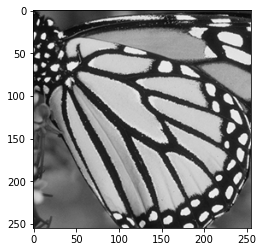

In [13]:
plt.imshow(HR_image, cmap='gray')

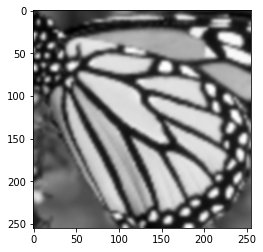

In [14]:
plt.imshow(LR_image, cmap='gray')

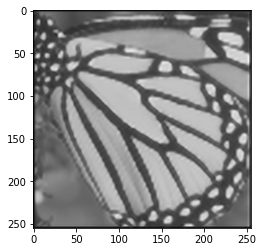

In [15]:
plt.imshow(SR_image, cmap='gray')